In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Conditional Latent Diffusion Training

In this notebook, we will train a simple `LatentDiffusionConditional` model in low resolution (64 by 64).

The training should take about 20 hours for reasonable results.

---

Maps dataset from the pix2pix paper:
```bash
wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
tar -xvf maps.tar.gz
```

In [13]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import pytorch_lightning as pl

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import imageio
from skimage import io
import os

from src import *
from train_latentDiffusion import get_dataset, MyLatentDiffusionConditional

mpl.rcParams['figure.figsize'] = (8, 8)

In [ ]:
import kornia
from kornia.utils import image_to_tensor
import kornia.augmentation as KA

class SimpleImageDataset(Dataset):
    """Dataset returning images in a folder."""

    def __init__(self,
                 root_dir,
                 transforms=None,
                 paired=True,
                 return_pair=False):
        self.root_dir = root_dir
        self.transforms = transforms
        self.paired=paired
        self.return_pair=return_pair
        
        # set up transforms
        if self.transforms is not None:
            if self.paired:
                data_keys=2*['input']
            else:
                data_keys=['input']

            self.input_T=KA.container.AugmentationSequential(
                *self.transforms,
                data_keys=data_keys,
                same_on_batch=False
            )   
        
        # check files
        supported_formats=['webp','jpg']        
        self.files=[el for el in os.listdir(self.root_dir) if el.split('.')[-1] in supported_formats]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()            

        img_name = os.path.join(self.root_dir,
                                self.files[idx])
        image = image_to_tensor(io.imread(img_name))/255

        if self.paired:
            c,h,w=image.shape
            slice=int(w/2)
            image2=image[:,:,slice:]
            image=image[:,:,:slice]
            if self.transforms is not None:
                out = self.input_T(image,image2)
                image=out[0][0]
                image2=out[1][0]
        elif self.transforms is not None:
            image = self.input_T(image)[0]

        if self.return_pair:
            return image2,image
        else:
            return image

In [ ]:
import torchvision.transforms as T

CROP_SIZE=256

T=[
    KA.RandomCrop((2*CROP_SIZE,2*CROP_SIZE)),
    KA.Resize((CROP_SIZE,CROP_SIZE),antialias=True),
    KA.RandomVerticalFlip()
  ]

train_ds=SimpleImageDataset('./data/maps/train',
                      transforms=T,
                      return_pair=True
                     )

test_ds=SimpleImageDataset('./data/maps/val',
                      transforms=T,
                      return_pair=True
                     )

img1,img2=train_ds[0]

plt.subplot(1,2,1)
plt.imshow(img1.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(img2.permute(1,2,0))

### Model Training

In [4]:
train_ds = get_dataset('../catphan/', 0, 512, (-1,1))

In [7]:
model=MyLatentDiffusionConditional(num_timesteps=1000,
                                 lr=1e-4,
                                 batch_size=8)

> /home/congliu/linatech/cbct_phantom/DiffusionFastForward/src/LatentDiffusion.py(27)__init__()
     25         self.model=AutoencoderKL.from_pretrained(model_type, local_file_only=True)
     26         import pdb; pdb.set_trace()
---> 27         print('AutoEncoder loaded')
     28 
     29     def forward(self,input):

AutoEncoder loaded
Is Time embed used ?  True


In [8]:
model.ae.encode(torch.ones(1,3,512,512)).shape

torch.Size([1, 4, 64, 64])

In [5]:
ct = train_ds[0]['ct'].repeat(3,1,1)
rct = model.ae(ct.unsqueeze(0))
ct.shape, rct.shape

(torch.Size([3, 256, 256]), torch.Size([1, 3, 256, 256]))

In [6]:
cbct = train_ds[0]['cbct'].repeat(3,1,1)
rcbct = model.ae(cbct.unsqueeze(0))
cbct.shape, rcbct.shape

(torch.Size([3, 256, 256]), torch.Size([1, 3, 256, 256]))

...but first, let's check if the used `AutoEncoder` (`model.ae`) can reconstruct our samples well.

**You should always test your autoencoder in this way when using latent diffusion models on a new dataset.**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


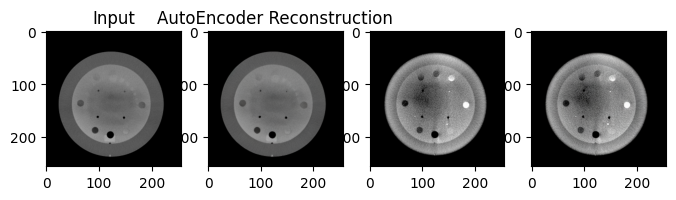

In [7]:
to01 = lambda x: (x+1)/2

plt.subplot(1,4,1)
plt.imshow(to01(ct.cpu().permute(1,2,0)))
plt.title('Input')
plt.subplot(1,4,2)
plt.imshow(to01(rct[0].cpu().detach().permute(1,2,0)))
plt.title('AutoEncoder Reconstruction')
plt.subplot(1,4,3)
plt.imshow(to01(cbct.cpu().permute(1,2,0)))
plt.subplot(1,4,4)
plt.imshow(to01(rcbct[0].cpu().detach().permute(1,2,0)))

In [ ]:
trainer = pl.Trainer(
    max_steps=2e5,
    callbacks=[EMA(0.9999)],
    gpus = [0]
)

In [ ]:
trainer.fit(model)

In [ ]:
input,output=test_ds[0]
batch_input=torch.stack(4*[input],0)

model.cuda()
out=model(batch_input, verbose=True)

In [ ]:
plt.subplot(1,2+len(out),1)
plt.imshow(input.permute(1,2,0))
plt.title('Input')
plt.axis('off')
for idx in range(out.shape[0]):
    plt.subplot(1,2+len(out),idx+2)
    plt.imshow(out[idx].detach().cpu().permute(1,2,0))
    plt.axis('off')
plt.subplot(1,2+len(out),2+len(out))
plt.imshow(output.permute(1,2,0))
plt.title('Ground Truth')
plt.axis('off')

By default, the `DDPM` sampler contained in the model is used, as above.

However, you can use a `DDIM` sampler just as well to reduce the number of inference steps:

In [ ]:
input,output=test_ds[0]
batch_input=torch.stack(4*[input],0)
STEPS=200 # ddim steps

ddim_sampler=DDIM_Sampler(STEPS,model.model.num_timesteps)

model.cuda()
out=model(batch_input,sampler=ddim_sampler,verbose=True)

In [ ]:
plt.subplot(1,2+len(out),1)
plt.imshow(input.permute(1,2,0))
plt.title('Input')
plt.axis('off')
for idx in range(out.shape[0]):
    plt.subplot(1,2+len(out),idx+2)
    plt.imshow(out[idx].detach().cpu().permute(1,2,0))
    plt.axis('off')
plt.subplot(1,2+len(out),2+len(out))
plt.imshow(output.permute(1,2,0))
plt.title('Ground Truth')
plt.axis('off')

In [1]:
from monai.transforms import Affine, Rand2DElastic
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from train_latentDiffusion import get_dataset

ct_name = os.path.join('../catphan/ct/102.png')
cbct_name = os.path.join('../catphan/cbct/102.png')


In [2]:
ds = get_dataset('../catphan/', cache_rate=0, img_shape=512, img_range=(0,1))

/home/congliu/miniconda3/envs/monai/lib/python3.11/site-packages/monai/transforms/spatial/array.py:2426: UserWarning: cache_grid=True is not compatible with the dynamic spatial_size, please specify 'spatial_size'.
  warnings.warn(


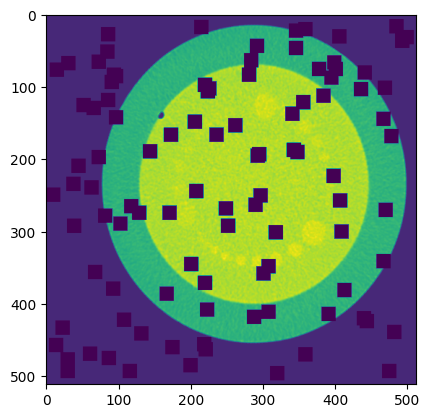

In [32]:
plt.imshow(ds[100]['ct'][0])

In [ ]:
fro

affine = Affine(
    rotate_params=np.pi / 4,
    scale_params=(1.2, 1.2),
    translate_params=(200, 40),
    padding_mode="zeros",
    device=torch.device("cuda:0"),
)
# convert both image and segmentation using different interpolation mode
new_img, _ = affine(im_data, (300, 400), mode="bilinear")
new_seg, _ = affine(seg_data, (300, 400), mode="nearest")
print(new_img.shape, new_seg.shape)